In [6]:
# used libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import json
import requests
import os
from dotenv import load_dotenv
import cartopy.crs as ccrs

In [24]:
# defined functions for pipeline

# Aquire dataset
def acquire():
    raw_data = pd.read_csv('data/database.csv')
    return raw_data

# Clean the dataset by dropping unused columns
def clean_nulls(raw_data):
    null_cols = raw_data.isnull().sum()
    drop_cols = list(null_cols[null_cols > 1000].index)
    data = raw_data.drop(drop_cols, axis=1)
    data = data.drop(['Type','ID','Source','Magnitude Type','Location Source', 'Magnitude Source','Status'], axis=1)
    return data

# Bininng the earthquakes according to magnitude
def binning_data(data):
    magnitude_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    bins = pd.cut(data['Magnitude'],5, labels=magnitude_labels)
    data['MagBin'] = bins
    binned_data = data
    return binned_data

# Filter the data according to the binned data
def filtering_data(binned_data):
    bins_delete = ['Very Low', 'Low']
    filtered_data = binned_data[~binned_data.MagBin.isin(bins_delete)]
    filtered_data = filtered_data.reset_index().drop(['index'], axis=1)
    return filtered_data

# Request to Open Cage info giving the coordenates as parameters
def api_opencage(filtered_data):
#https://opencagedata.com/demo
    location = []
    load_dotenv('.env')
    key = os.environ.get("oc_key")
    for i in range(len(filtered_data.head())): 
        try:
            lat = filtered_data['Latitude'][i]
            long = filtered_data['Longitude'][i]
            url = ('https://api.opencagedata.com/geocode/v1/json?q={}%2C{}&key={}&language=en&pretty=1&no_annotations=1'.format(lat,long,key))
            response = requests.get(url)
            results = response.json()
            continent = results['results'][0]['components']['continent']
            country = results['results'][0]['components']['country']
            state = results['results'][0]['components']['state']
        except:
            continent = 'No continent'
            country = 'No country'
            state = 'No state'
        location.append([continent, country, state])
    locdf = pd.DataFrame(location, columns = ['Continent', 'Country', 'State'])
    data_loc = pd.concat([filtered_data, locdf], axis=1, sort=False)
    return data_loc

# Display the 15 most powerfull earthquakes in the dataset
def top15_eq(data_loc):
    top_mag = data_loc.sort_values(by='Magnitude', ascending=False)
    return top_mag.head(15)

# Plot depth vs magnitude of each earthquake
def plot_depth_mag(data_loc):
    plt.figure(figsize=(10, 8))
    style.use('ggplot')
    sc_plot = sns.scatterplot('Depth', 'Magnitude', size='Magnitude', data=data_loc, hue='Continent')
    return sc_plot

# Plot the location of each eq in a world map
def point_map(data_loc):
    wmap_eq = plt.figure(figsize=(10, 5))
    ax = wmap_eq.add_subplot(1, 1, 1,projection=ccrs.PlateCarree(central_longitude=-150))
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.scatter(data_loc['Longitude']+150,data_loc['Latitude'])
    return wmap_eq

# Save the images as outputs
def save_img(sc_plot, wmap_eq, top_mag):
    fig1 = sc_plot.get_figure()
    fig1.savefig('output/mag_vs_depth.png')
    fig2 = wmap_eq
    fig2.savefig('output/earthquakes_worldmap.png')
    top_mag.to_csv('output/top15.txt')


,Date,Time,Latitude,Longitude,Depth,Magnitude,MagBin,Continent,Country,State
641,03/11/2011,05:46:24,38.2970,142.3730,29.00,9.1,Very High,NaN,NaN,NaN
541,12/26/2004,00:58:53,3.2950,95.9820,30.00,9.1,Very High,NaN,NaN,NaN
615,02/27/2010,06:34:12,-36.1220,-72.8980,22.90,8.8,Very High,NaN,NaN,NaN
1,02/04/1965,05:01:22,51.2510,178.7150,30.30,8.7,Very High,No continent,No country,No state
545,03/28/2005,16:09:37,2.0850,97.1080,30.00,8.6,Very High,NaN,NaN,NaN
660,04/11/2012,08:38:37,2.3270,93.0630,20.00,8.6,Very High,NaN,NaN,NaN
573,09/12/2007,11:10:27,-4.4380,101.3670,34.00,8.4,Very High,NaN,NaN,NaN
491,06/23/2001,20:33:14,-16.2650,-73.6410,33.00,8.4,Very High,NaN,NaN,NaN
714,09/16/2015,22:54:33,-31.5729,-71.6744,22.44,8.3,High,NaN,NaN,NaN
563,11/15/2006,11:14:14,46.5920,153.2660,10.00,8.3,High,NaN,NaN,NaN


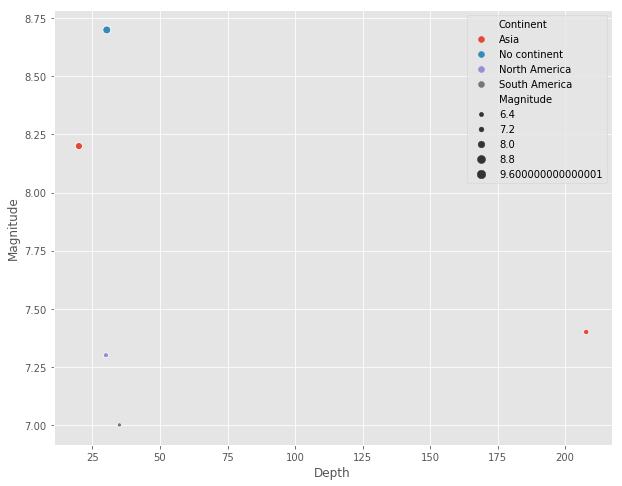

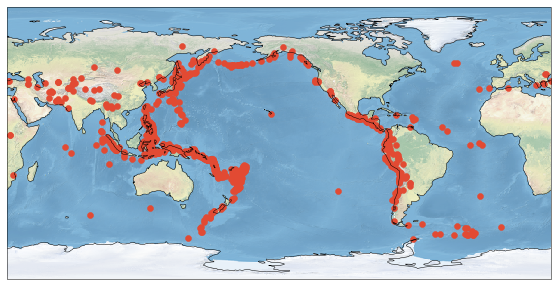

In [25]:
# Pipeline to get outputs
if __name__ == '__main__':
    raw_data = acquire()
    data = clean_nulls(raw_data)
    binned_data = binning_data(data)
    filtered_data = filtering_data(binned_data)
    data_loc = api_opencage(filtered_data)
    top_mag = top15_eq(data_loc)
    sc_plot = plot_depth_mag(data_loc)
    wmap_eq = point_map(data_loc)
    save_img(sc_plot, wmap_eq, top_mag)
    display(top_mag)